In [ ]:
# !pip install lightly
# !pip install scikit-dimension

In [19]:
%load_ext autoreload
%autoreload 2

In [1]:
import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as T

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(DEVICE)

cuda


In [2]:
# utils and metrics
from skdim.id import MLE # Maximum-Likelihood ID esimation

def model_param_count(model):
    return sum([np.prod(p.shape) for p in model.parameters()])

def plot_images(images, mean, std, n):
    denorm_transform = T.Normalize((-torch.tensor(mean) / torch.tensor(std)).tolist(), (1.0 / torch.tensor(std)).tolist())
    x = denorm_transform(images)
    x = torch.clip(x, 0., 1.)

    _, axs = plt.subplots(n // 10, 10, figsize=(11, 5))
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(x[idx].permute(1, 2, 0).numpy())
        ax.axis('off')
    plt.tight_layout()
    plt.show()


class MeanSquareDistancesStat:
    def __init__(self, ds_size, batch_size, n_epochs, hidden_dim, track_mle=True, mle_kwrgs={}):
        """
        ds_size: size of dataset
        batch_size: size of batch
        hidden_dim: dimension of representations
        """
        self.last_epoch_repr = torch.zeros(ds_size, hidden_dim,requires_grad=False)
        self.msd_hist = torch.zeros(n_epochs, ds_size, requires_grad=False)
        self.batch_size = batch_size
        
        self.track_mle = track_mle
        self.mle_hist = np.zeros((n_epochs, ds_size))
        self.mle_est = MLE(**mle_kwrgs)
        
        self.n_samples = ds_size
        self.n_epochs = n_epochs
        
        self.cur_batch = 0
        self.cur_epoch = 0

    @torch.no_grad()
    def msd(self, x_prev, x_next):
        return torch.mean((x_next - x_prev) ** 2, dim=1)

    def push(self, x_enc_batch):
        if self.cur_epoch == self.n_epochs: raise ValueError('Statistics is already collected')
        
        l, r = self.cur_batch * self.batch_size, (self.cur_batch + 1) * self.batch_size
        
        x_repr_prev = self.last_epoch_repr[l:r]

        self.msd_hist[self.cur_epoch, l:r] = self.msd(x_repr_prev, x_enc_batch).cpu()
        
        self.last_epoch_repr[l:r] = x_enc_batch
        self.cur_batch += 1

    def inc_epoch(self):
        if self.track_mle:
            self.mle_hist[self.cur_epoch] = self.mle_est.fit_transform_pw(self.last_epoch_repr.numpy())
        
        if self.cur_epoch == self.n_epochs: raise ValueError
        self.cur_epoch += 1
        self.cur_batch = 0

## Self-Supervised Contrastive Models

## Barlow Twins
https://arxiv.org/abs/2103.03230

In [3]:
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLView1Transform,
    BYOLView2Transform,
    MultiViewTransform
)
from lightly.transforms.utils import IMAGENET_NORMALIZE

class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

In [4]:
CHS = 3
IMG_SIZE = (32, 32)
BS = 128

class BYOLTransformWrapped(MultiViewTransform):
        """Appends BYOL transform output with not augmented images"""
        def __init__(self, view_1_transform, view_2_transform):
                view_1_transform = view_1_transform or BYOLView1Transform()
                view_2_transform = view_2_transform or BYOLView2Transform()
                transforms = [
                        T.Compose([T.ToTensor(), T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])]),
                        view_1_transform, 
                        view_2_transform
                ]
                super().__init__(transforms=transforms)


transform_train = BYOLTransformWrapped( # note: this thing works only with 3
        view_1_transform=BYOLView1Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
        view_2_transform=BYOLView2Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
)

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])
])

ds_train = datasets.CIFAR10(root='../data', transform=transform_train, download=True)
# ds_test = datasets.CIFAR10(root='../data', transform=transform_test, download=True)
train_loader = DataLoader(ds_train, batch_size=BS, shuffle=False, drop_last=True) # don't shuffle
# test_loader = DataLoader(ds_test, batch_size=BS, shuffle=False, drop_last=False)

Files already downloaded and verified


In [5]:
len(ds_train), next(iter(train_loader))[0][0].shape

(50000, torch.Size([128, 3, 32, 32]))

In [6]:
# backbone = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(CHS*np.prod(IMG_SIZE), 512),
#     nn.ELU(),
#     nn.Linear(512, 512),
#     nn.ELU()
# )

# backbone = torchvision.models.vgg11().features 
backbone = nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
print(model_param_count(backbone))

11176512


In [10]:
# MSD experiment
import gc

NUM_EPOCHS=20

model = BarlowTwins(backbone).to(DEVICE)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
msd_tracker = MeanSquareDistancesStat(len(ds_train), BS, NUM_EPOCHS, hidden_dim=2048, track_mle=False)

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for x, _ in train_loader:
        model.train()
        x_orig, x0, x1 = x
        x_orig = x_orig.to(DEVICE)
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)

        z0 = model(x0)
        z1 = model(x1)

        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            z = model(x_orig)
            z = z.cpu()
            msd_tracker.push(z)

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    msd_tracker.inc_epoch()

    torch.cuda.empty_cache()
    gc.collect()

    print(f"mean msd: {np.mean(msd_tracker.msd_hist[epoch].cpu().detach().numpy()):.3f}")

epoch: 00, loss: 1210.40417
mean msd: 9.163
epoch: 01, loss: 1089.85864
mean msd: 13.079
epoch: 02, loss: 1015.98041
mean msd: 14.177
epoch: 03, loss: 972.38416
mean msd: 14.267
epoch: 04, loss: 939.42511
mean msd: 15.744
epoch: 05, loss: 903.74231
mean msd: 16.973
epoch: 06, loss: 878.95654
mean msd: 18.548
epoch: 07, loss: 850.73938
mean msd: 19.607
epoch: 08, loss: 826.99023
mean msd: 20.250
epoch: 09, loss: 806.66760
mean msd: 21.547
epoch: 10, loss: 790.67932
mean msd: 21.556
epoch: 11, loss: 774.35876
mean msd: 22.870
epoch: 12, loss: 761.35132
mean msd: 24.399
epoch: 13, loss: 748.75488
mean msd: 24.463
epoch: 14, loss: 738.58813
mean msd: 24.616
epoch: 15, loss: 723.37604
mean msd: 26.185
epoch: 16, loss: 720.01282
mean msd: 28.085
epoch: 17, loss: 709.15741
mean msd: 28.736
epoch: 18, loss: 696.99481
mean msd: 28.999
epoch: 19, loss: 691.24292
mean msd: 29.617


## MSD analysis

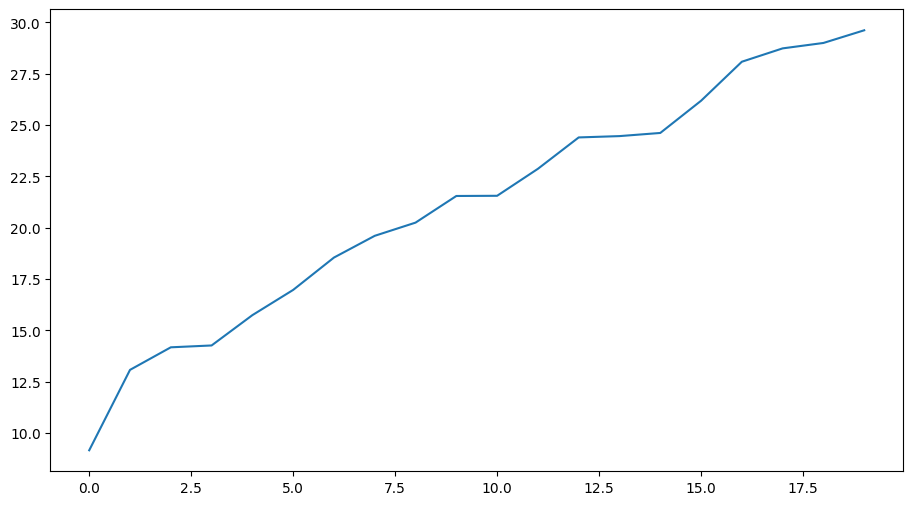

In [12]:
plt.figure(figsize=(11, 6))
msd_hist = np.array(msd_tracker.msd_hist[:NUM_EPOCHS])
plt.plot(msd_hist.mean(axis=1))
plt.show()

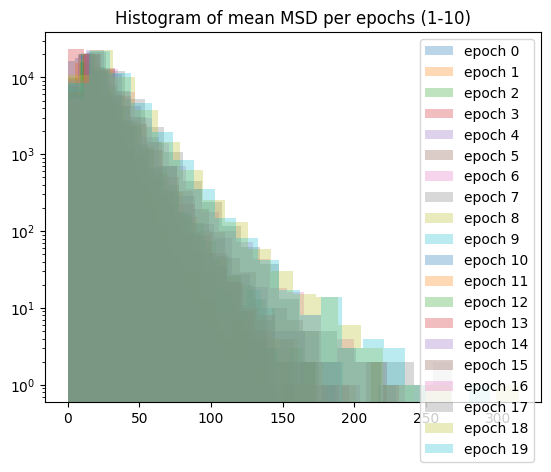

In [15]:
for ep in range(NUM_EPOCHS):
    plt.hist(msd_hist[ep, :], bins=20, alpha=0.3, label=f'epoch {ep}', log=True)
plt.title("Histogram of mean MSD per epochs (1-10)")
plt.legend()
plt.show()

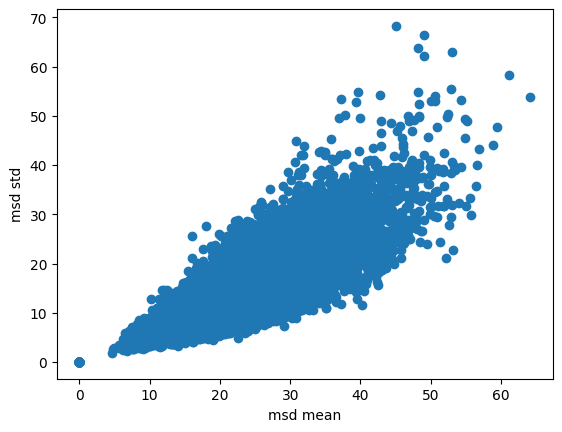

In [16]:
# mean and std of each sample msd
msd_means = msd_hist.mean(axis=0)
msd_stds = msd_hist.std(axis=0)

# plot scatter plot
plt.scatter(msd_means, msd_stds)
plt.xlabel('msd mean')
plt.ylabel('msd std')
plt.show()

### Samples by MSD from "first half"

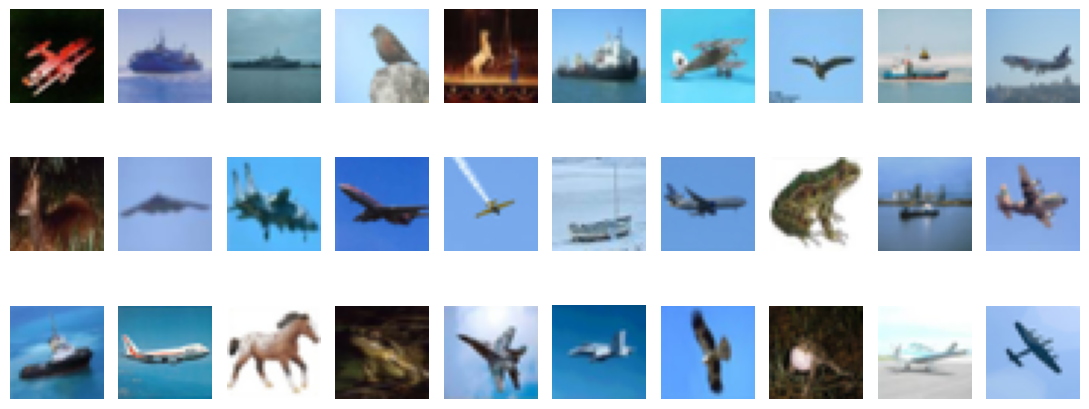

In [20]:
# images with maximum mean msd
N=30
imgs = torch.cat([ds_train[idx][0][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_means)[-N:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], n=N) 

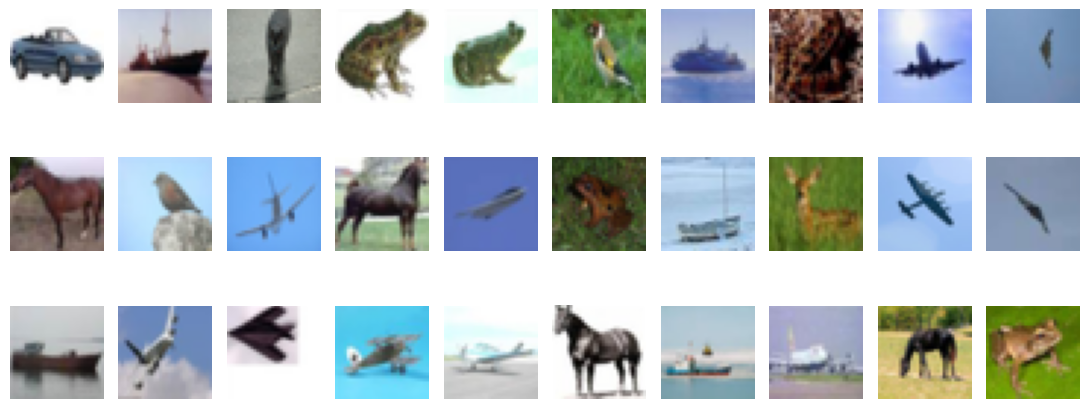

In [23]:
# images with max mean std of msd
imgs = torch.cat([ds_train[idx][0][0].reshape(1, 3, 32, 32) for idx in np.argsort(msd_stds)[-N:]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N)

In [27]:
msd_means.shape

(50000,)

In [41]:
# remove zeros caused by removed last batch
- len(msd_means_no_zeros) + len(msd_means[msd_means == 0]) # 80

80

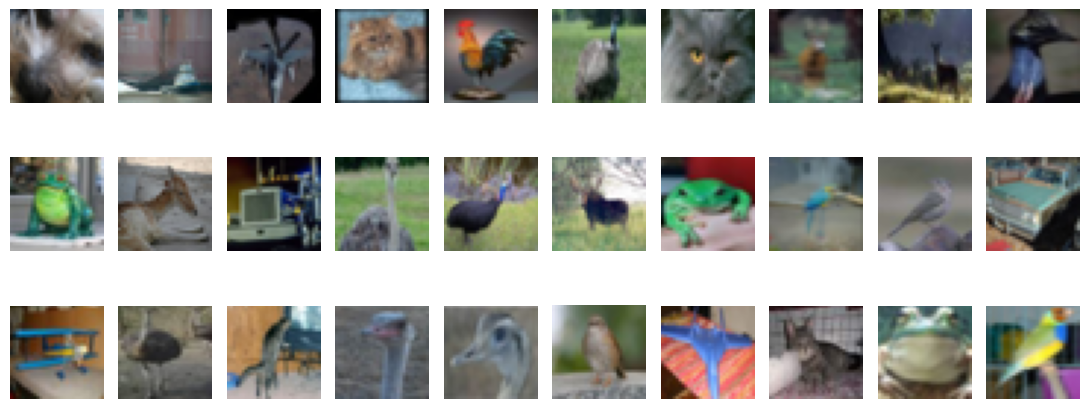

In [46]:
msd_means_no_zeros = msd_means[np.isclose(msd_means, 1e-6)]

sorted_idx = np.argsort(msd_means)
sorted_idx = sorted_idx[80:] # remove zeros caused by removed last batch
imgs = torch.cat([ds_train[idx][0][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N) 

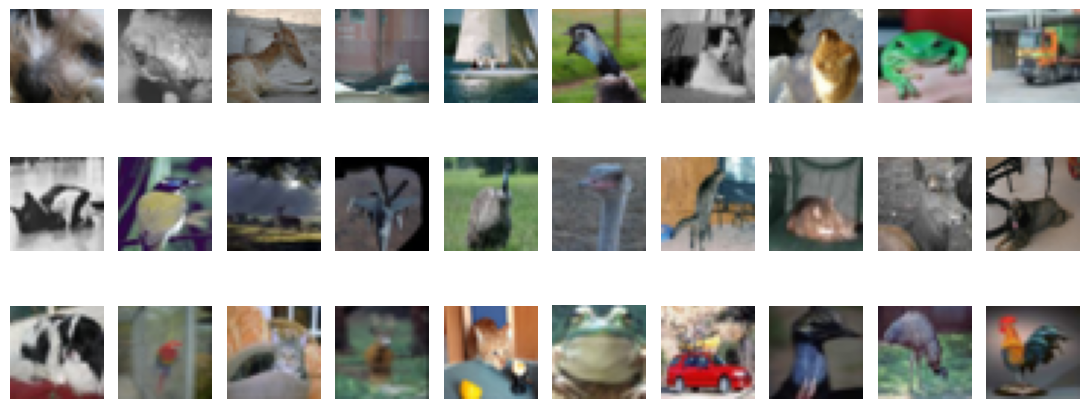

In [47]:
sorted_idx = np.argsort(msd_stds)
sorted_idx = sorted_idx[80:] # remove zeros caused by removed last batch
imgs = torch.cat([ds_train[idx][0][0].reshape(1, 3, 32, 32) for idx in sorted_idx[:N]])
plot_images(imgs, IMAGENET_NORMALIZE["mean"], IMAGENET_NORMALIZE["std"], N) 